In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
from copy import deepcopy
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_PATH = os.path.join("./drive", "MyDrive", "cs3244-pg26")
PROCESSED_DATA_PATH = os.path.join("data_processed", "resale_flat_prices")
SEED = 42

In [4]:
df = pd.read_csv(os.path.join(DRIVE_PATH, PROCESSED_DATA_PATH, "engineered_data.csv"))
df.head(10)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
5,6,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,552.504039,NaN
6,7,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,...,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1,61.9,1223.949919,NaN
7,8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,...,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1,61.9,2008.841636,NaN
8,9,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,...,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1,61.9,2048.553788,NaN
9,10,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,...,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1,61.9,1194.668821,NaN


In [5]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))
df.head(5)

,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,0.763427
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,0.763427
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,0.763427
3,4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,0.763427
4,5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,0.763427


### Preprocessing columns to train

In [6]:
def process_df(df):
  new_df = deepcopy(df)
  new_df["period_index"] = pd.PeriodIndex(df.sale_date, freq="Q")
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df



In [7]:
new_df = process_df(df)

In [8]:
new_df.columns

Index(['floor', 'age', 'relative_tenure', 'floor_area', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora', 'period_index',
       'flat_type_3_ROOM', 'flat_type_4_ROOM', 'flat_type_5_ROOM',
       'flat_type_EXECUTIVE', 'flat_type_OTHER', 'flat_model_APARTMENT',
       'flat_model_IMPROVED', 'flat_model_MAISONETTE', 'flat_model_MODEL_A',
       'flat_model_MODEL_A2', 'flat_model_NEW_GENERATION', 'flat_model_OTHER',
       'flat_model_PREMIUM_APARTMENT', 'flat_model_SIMPLIFIED',
       'flat_model_STANDARD', 'town_ANG_MO_KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT_BATOK', 'town_BUKIT_MERAH', 'town_BUKIT_PANJANG',
       'town_CHOA_CHU_KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG_EAST', 'town_JURONG_WEST', 'town_KALLANG/WHAMPOA'

### Model design and training

In [17]:
def train_test_split(df, period):
  train = df[df["period_index"] != period]
  test = df[df["period_index"] == period]
  
  X_train, y_train = train[train.columns.difference(["cpi_psm", "period_index"])], train["cpi_psm"]
  X_test, y_test = test[test.columns.difference(["cpi_psm", "period_index"])], test["cpi_psm"]
  return X_train, X_test, y_train, y_test

In [33]:

X_train, X_test, y_train, y_test = train_test_split(new_df, pd.Period(value="2022", freq="Q"))

In [35]:
X_test.shape

(6524, 56)

In [38]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(56, activation="relu", input_shape=(56,)),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1, activation="linear")
])

In [39]:
model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 56)                3192      
                                                                 
 dense_16 (Dense)            (None, 20)                1140      
                                                                 
 dense_17 (Dense)            (None, 1)                 21        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [40]:
checkpoint_path = "model_checkpoints_basic/cp-{epoch:04d}.ckpt"

batch_size = 1024

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(DRIVE_PATH, checkpoint_path), 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

model.save_weights(checkpoint_path.format(epoch=0))

In [41]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=1000, validation_split=0.10, shuffle=True, callbacks=[cp_callback], verbose=1)

Epoch 1/1000
756/756 [==============================] - 4s 4ms/step - loss: 4187002.7500 - mse: 4187002.7500 - mae: 1489.6578 - val_loss: 2813451.2500 - val_mse: 2813451.2500 - val_mae: 1421.5345
Epoch 2/1000
756/756 [==============================] - 3s 4ms/step - loss: 952049.1250 - mse: 952049.1250 - mae: 735.9547 - val_loss: 2123027.7500 - val_mse: 2123027.7500 - val_mae: 1148.9479
Epoch 3/1000
756/756 [==============================] - 3s 4ms/step - loss: 703933.3125 - mse: 703933.3125 - mae: 626.9799 - val_loss: 1444273.8750 - val_mse: 1444273.8750 - val_mae: 974.3679
Epoch 4/1000
756/756 [==============================] - 3s 4ms/step - loss: 500457.5625 - mse: 500457.5625 - mae: 529.7733 - val_loss: 1088528.0000 - val_mse: 1088528.0000 - val_mae: 862.0566
Epoch 5/1000
756/756 [==============================] - 3s 4ms/step - loss: 403808.1562 - mse: 403808.1562 - mae: 474.9908 - val_loss: 840140.1250 - val_mse: 840140.1250 - val_mae: 746.5213
Epoch 6/1000
756/756 [===============

### Model analysis

In [42]:
y_pred = model.predict(X_test)

204/204 [==============================] - 0s 1ms/step


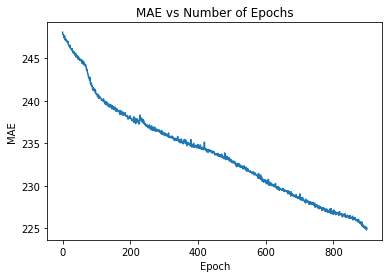

In [43]:
import matplotlib.pyplot as plt
plt.subplot(111)
plt.plot(history.history["mae"][100:])
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE vs Number of Epochs")
plt.show()

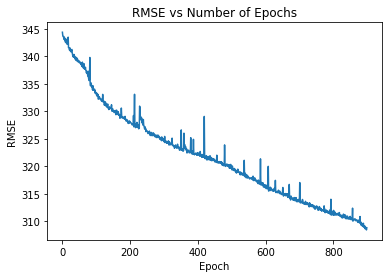

In [44]:
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("RMSE vs Number of Epochs")
plt.plot(np.sqrt(history.history["mse"][100:]))
plt.show()

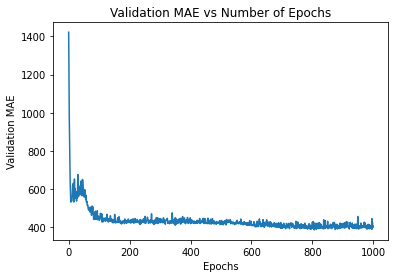

In [45]:
plt.subplot(111)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Validation MAE vs Number of Epochs")
plt.plot(history.history["val_mae"])
plt.show()

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error
def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [47]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 379757.2750435624
RMSE: 616.2444929113464
MAE: 491.00536153314204
R2: 0.7975996242593902
MAPE: 0.08586344280628415
MdAPE: 0.07911652666476798


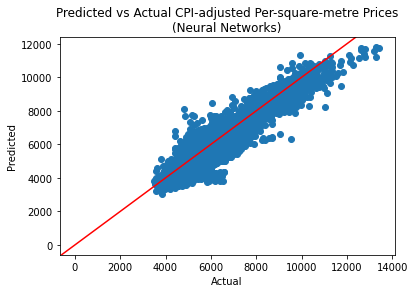

In [48]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(Neural Networks)")
plt.axline((0.0, 0.0), slope =1, color = "red")
plt.show()

In [49]:
y_pred_reshaped = np.reshape(y_pred, -1)
y_pred_series = pd.Series(y_pred_reshaped, name="y_pred")

test_df = X_test.merge(y_test, left_index=True, right_index=True)
test_pred_df = test_df.merge(y_pred_series, left_index = True, right_index = True)


In [50]:
test_pred_df.head(20)

,age,avg_sora,cpi,flat_model_APARTMENT,flat_model_IMPROVED,flat_model_MAISONETTE,flat_model_MODEL_A,flat_model_MODEL_A2,flat_model_NEW_GENERATION,flat_model_OTHER,...,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN,cpi_psm,y_pred


In [51]:
test_pred_df.to_csv(os.path.join(DRIVE_PATH, PROCESSED_DATA_PATH, "test_pred_basic_df_4.csv"))
pd.DataFrame.from_dict(history.history).to_csv(os.path.join(DRIVE_PATH, PROCESSED_DATA_PATH, 'history_basic_4.csv'),index=False)
model.save(os.path.join(DRIVE_PATH, PROCESSED_DATA_PATH, "model_v3_basic.h5"))

In [52]:
from google.colab import runtime
runtime.unassign()